In [ ]:
# get new data from github repository https://github.com/CSSEGISandData/COVID-19
import subprocess
process = subprocess.Popen("cd COVID-19; git fetch; git pull",stdout=subprocess.PIPE, shell=True)


In [ ]:
# imports and globals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
BASE_DIRECTORY = "COVID-19\\csse_covid_19_data\\csse_covid_19_time_series\\"

COUNTRY_DATA = {
    "United Kingdom": {
        "population": 66440000, #2018
        "province": "",
    },
    "France": {
        "population": 66990000, #2019
        "province": "",
    },
    "Germany": {
        "population": 82790000, #2018
        "province": "",
    },
    "Spain": {
        "population":46660000, #2018
        "province": "",
    },
    "Italy" : {
        "population":60480000, #2018
        "province": "",
    },
    "China" : {
        "population": 59020000, # 2017 just Hubei
        "province": "Hubei",
    },
    "Korea, South": {
        "population": 51470000, #2017
        "province": "",
    }
}


In [166]:
# load the datasets
confirmed = pd.read_csv(join(BASE_DIRECTORY, "time_series_covid19_confirmed_global.csv"))
deaths = pd.read_csv(join(BASE_DIRECTORY, "time_series_covid19_deaths_global.csv"))
recovered = pd.read_csv(join(BASE_DIRECTORY, "time_series_covid19_recovered_global.csv"))

In [167]:
# load the US dataset (which is in a different format)
# Only going to look at US overall for now
confirmed_US = pd.read_csv(join(BASE_DIRECTORY,"time_series_covid19_confirmed_US.csv"))
confirmed_US_sum = pd.Series()
deaths_US = pd.read_csv(join(BASE_DIRECTORY,"time_series_covid19_deaths_US.csv"))
deaths_US_sum = pd.Series()
for column in confirmed_US:
    try:
        confirmed_US_sum[column] = int(confirmed_US[column].sum())
        deaths_US_sum[column] = int(deaths_US[column].sum())
    except Exception as e:
        confirmed_US_sum[column] = ""
        deaths_US_sum[column] = ""

In [168]:
# merge the US set with the others
# Need to reformat it a bit
try:
    confirmed_US_sum = confirmed_US_sum.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'])
    deaths_US_sum = deaths_US_sum.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'])
except:
    # already done
    pass

for column in ['Province/State', 'Country/Region', 'Lat', 'Long']:
    confirmed_US_sum[column] = "US"

In [110]:

# US dates are in the wrong format... 👿
# this should only be run once
def convert_idiotic_american_date(dumb_date):
    # M/D/Y
    try:
        a = dumb_date.split("/")
        correct_date_format = a[1] + "/" + a[0] + "/" + a[2]
        return correct_date_format
    except:
        # not a date
        return dumb_date

# confirmed_US_sum.index = [convert_idiotic_american_date(x) for x in confirmed_US_sum.index]
# deaths_US_sum.index = [convert_idiotic_american_date(x) for x in deaths_US_sum.index]

In [169]:
# merge the datasets
confirmed = pd.concat([confirmed_US_sum.to_frame().T, confirmed], ignore_index=True)
deaths = pd.concat([deaths_US_sum.to_frame().T, deaths], ignore_index=True)

In [170]:
confirmed

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,4/1/20,Country/Region,Lat,Long,Province/State
0,1,1,2,2,5,5,5,5,5,7,...,172,217,336,450,514,213362,US,US,US,US
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,4,4,237,Afghanistan,33,65,NaN
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,259,Albania,41.1533,20.1683,NaN
3,0,0,0,0,0,0,0,0,0,0,...,12,17,17,19,20,847,Algeria,28.0339,1.6596,NaN
4,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,390,Andorra,42.5063,1.5218,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,6,United Kingdom,21.694,-71.7979,Turks and Caicos Islands
253,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,9,MS Zaandam,0,0,NaN
254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4,Botswana,-22.3285,24.6849,NaN
255,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,Burundi,-3.3731,29.9189,NaN


In [128]:

def load(country: str, state: str) -> pd.DataFrame:
    """
    returns a country as a pandas dataframes with confirmed, deaths, recovered as columns, dates as index
    """
    # could do the following as a loop but eh

    # confirmed
    country_df = confirmed[confirmed['Country/Region'] == country].replace(np.nan, "")
    state_df = country_df[country_df['Province/State'] == state]
    confirmed_result = state_df.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1).T

    # deaths
    country_df = deaths[deaths['Country/Region'] == country].replace(np.nan, "")
    state_df = country_df[country_df['Province/State'] == state]
    deaths_result = state_df.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1).T

    # recovered
    country_df = recovered[recovered['Country/Region'] == country].replace(np.nan, "")
    state_df = country_df[country_df['Province/State'] == state]
    recovered_result = state_df.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1).T

    # combine the series to one dataframe
    df_result = pd.concat([confirmed_result, deaths_result, recovered_result], axis =1)
    df_result.columns = ["confirmed", "deaths", "recovered"]
    df_result.index = pd.to_datetime(df_result.index)

    return df_result


In [171]:
# load the data for each country into the dictionary

for country in COUNTRY_DATA.keys():
    # get the data
    df = load(country, COUNTRY_DATA[country]['province'])
    COUNTRY_DATA[country]['data'] = df
    # Normalise data with population figures
    normalise = lambda x: x/COUNTRY_DATA[country]['population'] * 100
    COUNTRY_DATA[country]['normalised_data'] = df.apply(normalise)


Text(0, 0.5, 'Percentage of the population')

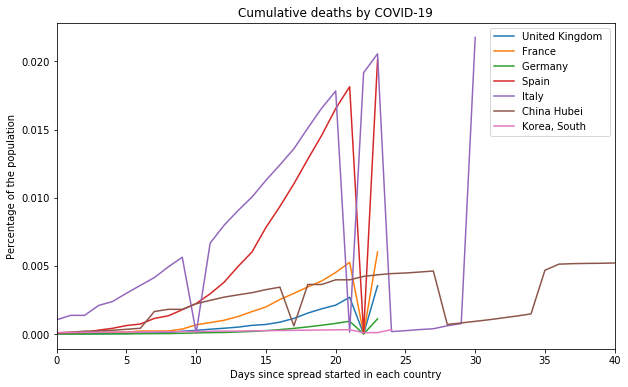

In [172]:
# Now we have normalised death values, we need normalised dates. We should only compare counties from the date the virus started killing
# Find the first day of a death for each country
first_day = lambda df: df.deaths[df.deaths <= 0.0001].index[-1]
# need to convert the index to days since the first day
convert_index = lambda df: df[df.index >= first_day(df)].reset_index()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
for country in COUNTRY_DATA.keys():
    ax.plot(convert_index(COUNTRY_DATA[country]['normalised_data']).deaths)
ax.legend([country + " " + COUNTRY_DATA[country]['province'] for country in COUNTRY_DATA.keys()])
ax.set_xlim([0, 40])
plt.title("Cumulative deaths by COVID-19")
plt.xlabel("Days since spread started in each country")
plt.ylabel("Percentage of the population")

In [ ]:
# plot an interactive version using bokeh

from bokeh.plotting import figure, show, output_file
from bokeh.palettes import Colorblind as palette
from itertools import cycle

output_file("log_lines.html")
colours = cycle(palette[8])

fig = figure(
    title="Cumulative deaths by COVID-19", 
    x_axis_label='Days since spread started in each country', 
    y_axis_label='Percentage of the population',
    plot_width=800,
    plot_height=500
    )

for country in COUNTRY_DATA.keys():
    series = convert_index(COUNTRY_DATA[country]['normalised_data']).deaths
    fig.line(series.index, series.values, legend_label=country, line_width=2, color=next(colours))

show(fig)

In [ ]:
# Now try to predict what the number of deaths will be in the future based on current trajectory (& the confirmed cases?)
